In [1]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from collections import defaultdict, Counter
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes


import src.helpers.MetricUtilities as metrics
from functools import partial

from mtree.mtree import MTree
import mtree.mtree as mtree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%reload_ext autoreload

%autoreload 2

cpu


In [171]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)

import torch
from torch.utils.data import Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from line_profiler import profile

import src.helpers.MetricUtilities as metrics


from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Put these in a separate file for MTreeUtils...
def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.distance, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFT(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFTNumba(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft_numba, max_node_size=k)
    tree.add_all(data)
    return tree

class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/imdb_wiki/"
        file_list = glob.glob(self.imgs_path + "*")
        self.images = []
        for class_path in file_list:
            for dir_path in glob.glob(class_path + "/*"):
                for img_path in glob.glob(dir_path + "/*.jpg"):
                    self.images.append(img_path)

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        image = transforms.functional.to_grayscale(image)

        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()



class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDataset(transform)

def get_data_MStar(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetMStar(transform)

def mtree_ncc_query_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_ncc = 0
    total_time_mtree = 0
    avg_times_ncc = []
    avg_times_mtree = []

    data = get_data_MStar(image_size)

    print(f"Average runtime of querying mtree and ncc for {k} NN over {runs} runs with image size {image_size} and max node size {max_node_size} and variable sample size")
    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_ncc = 0
        total_time_mtree = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        sampled_test_data = Subset(data, sample_indices)

        testSample = [item[0] for item in sampled_test_data]
        

        tree = getMTree(testSample, max_node_size)

        # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
        # t_MNIST_data = trans(MNIST_data)

        # for img in MNIST_data:
        #     img = trans(img)

        for _ in range(runs):
            index1 = np.random.randint(len(data))
            #input1=input_dataset[index1][0].squeeze().to('cpu')
            unseen_image = data[index1][0]

            start_time = time.time()
            arr = []
            for j in range(len(testSample)):
                result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
                arr.append(result)
            
            unseen_img_arr = np.array(arr)
            #print(unseen_img_arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            end_time = time.time()

            total_time_ncc += end_time - start_time

            start_time = time.time()
            imgs = getKNearestNeighbours(tree, unseen_image, k+1)
            end_time = time.time()
            total_time_mtree += end_time - start_time

        avg_ncc = total_time_ncc / runs
        avg_mtree = total_time_mtree / runs
        avg_times_ncc.append(avg_ncc)
        avg_times_mtree.append(avg_mtree)

        # with open("test_mtree_query_sample_sizes_avg_times_ncc_.txt", "w") as file:
        #     file.write(f"avg times: {str(avg_times_ncc)}")
        
        # with open("test_mtree_query_sample_sizes_avg_times_mtree_.txt", "w") as file:
        #     file.write(f"avg times: {str(avg_times_mtree)}")

        print(f"Average runtime of ncc search: {avg_ncc:.6f} seconds")
        print(f"Average runtime of mtree search: {avg_mtree:.6f} seconds")
    # plot_data_mtree_ncc(x_axis="Sample size", title=f"Average runtime of finding {k} neighbours with image size {image_size} against sample sizes", filename="test_mtree_query_sample_sizes.png", 
    #                     varied_arr=sample_sizes, data1=avg_times_ncc, data2=avg_times_mtree, max_node_size=max_node_size)


def mtree_init_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_mtree_init = 0
    avg_times_mtree_init = []

    data = get_data_MStar(image_size)

    print(f"Average runtime of initialising mtree over {runs} runs with max node size {max_node_size} and image size {image_size} and variable sample sizes")

    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_mtree_init = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        sampled_test_data = Subset(data, sample_indices)

        testSample = [item[0] for item in sampled_test_data]
        #sampled_test_data[:,0]

        for _ in range(runs):
            start_time = time.time()
            tree = getMTree(testSample, max_node_size)
            end_time = time.time()
            total_time_mtree_init += end_time - start_time
            print(f"Finished one run of mtree init...")

        
        avg_mtree_init = total_time_mtree_init / runs
        avg_times_mtree_init.append(avg_mtree_init)

        
        # with open("test_mtree_init_sample_sizes_avg_times_mtree_init.txt", "w") as file:
        #     file.write(f"avg times: {str(avg_times_mtree_init)}")

        print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")
    
    # plot_data_mtree_init(x_axis="Sample size", title=f"Average runtime of initialising mtree with image size {image_size}, max node size {max_node_size} against sample sizes", filename="test_mtree_init_sample_sizes.png", 
    #                     varied_arr=sample_sizes, data=avg_times_mtree_init, max_node_size=max_node_size)

In [172]:
# 9466 samples
# note MStar is 368 by 368...

mtree_ncc_query_sample_size(max_node_size=15, image_size=368, k=7, runs=10, sample_sizes=[10, 100, 1000, 2000])

Average runtime of querying mtree and ncc for 7 NN over 10 runs with image size 368 and max node size 15 and variable sample size
NOW TRYING sample size: 10


NameError: name 'ImageProducts' is not defined

In [179]:
import json
# TODO look at train/val/test.json format and extract out the category id and the id to class mapping at the v end.
class CustomDatasetSARDet_100k(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/SARDet_100k/SARDet_100K/JPEGImages/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []

        # with open("../data/SARDet_100k/SARDet_100K/mapping.json") as annotations:
        #     mappings = json.load(annotations)

        for dir_path in file_list:
            for img_path in glob.glob(dir_path + "/*.png"):
                # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
                self.data.append([img_path, "yippee"])
            for img_path in glob.glob(dir_path + "/*.jpg"):
                # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
                self.data.append([img_path, "yippee"])
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        # class_id = self.class_map[data_path[1]]
        class_id = data_path[1]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data_SARDet_100k(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetSARDet_100k(transform)


In [182]:
data = get_data_SARDet_100k(300)
print(len(data))
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
classes = [item[1] for item in sampled_test_data]


115715


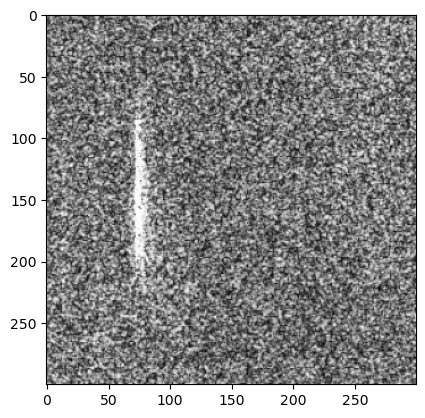

In [184]:
index1 = np.random.randint(len(testSample))
#index2 = np.random.randint(len(testSample))
#input2=input_dataset[index2][0].squeeze().to('cpu')
plt.imshow(testSample[index1], cmap='grey')
plt.show()


In [21]:

k=7
data = get_data_MStar(368)
print(len(data))
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
classes = [item[1] for item in sampled_test_data]

# class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

tree = getMTree(testSample, 12)

index1 = random.choice(sample_indices)
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]
unseen_image_class = data[index1][1]

arr = []
for j in range(len(testSample)):
    result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
    arr.append(result)

unseen_img_arr = np.array(arr)
#print(unseen_img_arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]

num_same_class = 0

print(f"Unseen img class: {unseen_image_class}")
for i in imgProd_max_index:
    img_class = classes[i]
    print(f"Index {i}, Class {img_class}")
    if (img_class == unseen_image_class):
        num_same_class += 1

print(num_same_class)


imgs = getKNearestNeighbours(tree, unseen_image, k+1)


def imgs_to_indices(img_arr, testSample):
    ind_arr = []
    for img in img_arr:
        for i in range(len(testSample)):
            if (metrics.distance(img, testSample[i]) < 0.00001):
                ind_arr.append(i)
                break
    
    return ind_arr

ind_arr = imgs_to_indices(imgs, testSample)
print(ind_arr)
print(imgProd_max_index)


9466


KeyboardInterrupt: 

In [6]:
import numpy as np
import cv2

def ncc(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc

    Applies NCC of the template image over the main image and returns the max value obtained.
    When the template image kernel exceeds the bounds, wraps to the other side of the main image
    """
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)

    corr = cv2.matchTemplate(mainImg, tempImg, cv2.TM_CCORR_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

    return max_val

def ncc_scaled(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc, with scaled bounds of [-1,1]
    """
    return ncc(mainImg, tempImg) * 2 - 1


class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

k=7
data = get_data_MStar(368)
print(len(data))
sample_indices = random.sample(range(len(data)), 10)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
classes = [item[1] for item in sampled_test_data]

# class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

tree = getMTree(testSample, 12)

index1 = random.choice(sample_indices)
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]
unseen_image_class = data[index1][1]

arr = []
for j in range(len(testSample)):
    result = ncc_scaled(testSample[j], unseen_image)
    arr.append(result)

unseen_img_arr = np.array(arr)
#print(unseen_img_arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]

num_same_class = 0

print(f"Unseen img class: {unseen_image_class}")
for i in imgProd_max_index:
    img_class = classes[i]
    print(f"Index {i}, Class {img_class}")
    if (img_class == unseen_image_class):
        num_same_class += 1

print(num_same_class)


imgs = getKNearestNeighbours(tree, unseen_image, k+1)


def imgs_to_indices(img_arr, testSample):
    ind_arr = []
    for img in img_arr:
        for i in range(len(testSample)):
            if (metrics.distance(img, testSample[i]) < 0.00001):
                ind_arr.append(i)
                break
    
    return ind_arr

ind_arr = imgs_to_indices(imgs, testSample)
print(ind_arr)
print(imgProd_max_index)


9466
Unseen img class: 3
Index 0, Class 4
Index 9, Class 1
Index 3, Class 2
Index 6, Class 4
Index 8, Class 5
Index 1, Class 5
Index 7, Class 6
Index 5, Class 3
1
[5, 7, 1, 8, 6, 3, 9, 0]
[0 9 3 6 8 1 7 5]


In [139]:
import scipy.fft
import math

def ncc(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc

    Applies NCC of the template image over the main image and returns the max value obtained.
    When the template image kernel exceeds the bounds, wraps to the other side of the main image
    """
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)

    corr = cv2.matchTemplate(mainImg, tempImg, cv2.TM_CCORR_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

    return max_val

def ncc_unnormed(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc

    Applies NCC of the template image over the main image and returns the max value obtained.
    When the template image kernel exceeds the bounds, wraps to the other side of the main image
    """
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)

    corr = cv2.matchTemplate(mainImg, tempImg, cv2.TM_CCORR)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

    return max_val

dataset = get_data_MStar(300)

sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
index2 = np.random.randint(len(testSample))
unseen_image = data[index1][0]


test_img = testSample[index2]
test_img2 = unseen_image
m = test_img.shape[0]

ncc_score_un = ncc_unnormed(test_img, test_img2)
ncc_score = ncc(test_img, test_img2)
print(ncc_score)


def ncc_fft(mainImg, tempImg):
    A = scipy.fft.fft2(mainImg)
    B = scipy.fft.fft2(tempImg)

    Z = scipy.fft.ifft2(np.conj(A) * B).real

    auto_A = scipy.fft.ifft2(np.conj(A) * A).real
    auto_B = scipy.fft.ifft2(np.conj(B) * B).real
    auto_A = np.maximum(auto_A, 0.0001)
    auto_B = np.maximum(auto_B, 0.0001)
    auto_A_sqrt = np.sqrt(auto_A)
    auto_B_sqrt = np.sqrt(auto_B)
    denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max() # (THIS WORKS.) (Basically uhm so the normalization amt should be the same throughout? I'm not v sure why this works...)

    return np.divide(Z, denom).max()

print(ncc_fft(test_img, test_img2))

def ncc_naive(mainImg, tempImg):
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)
    m = tempImg.shape[0]
    ncc_arr = np.ones((2*m, 2*m))
    for i in range(2 * m):
        for j in range(2 * m):
            sum = 0
            sum_norm_main = 0
            sum_norm_temp = 0
            for x in range(m):
                for y in range(m):
                    sum += mainImg[x + i][y + j] * tempImg[x][y]
                    sum_norm_main += (mainImg[x+i][y+j])**2
                    sum_norm_temp += (tempImg[x][y])**2
            
            ncc_arr[i][j] = (sum) / (math.sqrt(sum_norm_main * sum_norm_temp))
    
    return ncc_arr.max()


# for i in range(100):
#     sample_indices = random.sample(range(len(data)), 100)
#     sampled_test_data = Subset(data, sample_indices)

#     testSample = [item[0] for item in sampled_test_data]
#     index1 = np.random.randint(len(data))
#     index2 = np.random.randint(len(testSample))
#     unseen_image = data[index1][0]


#     test_img = testSample[index2]
#     test_img2 = unseen_image
#     m = test_img.shape[0]

#     ncc_score = ncc(test_img, test_img2)
#     ncc_fft_score = ncc_fft(test_img, test_img2)
#     if (abs(ncc_score - ncc_fft_score) > 0.00001):
#         print(ncc_score)
#         print(ncc_fft_score)

# print(ncc_naive(test_img, test_img2))

0.9854661226272583
0.9854662


## TEST NUMBA

In [128]:
import numba as nb

@nb.njit
def ncc_fft_numba(mainImg, tempImg):
    A = scipy.fft.fft2(mainImg)
    B = scipy.fft.fft2(tempImg)

    Z = scipy.fft.ifft2(np.conj(A) * B).real
    # IT'S OK UP TO THIS POINT!!

    auto_A = scipy.fft.ifft2(np.conj(A) * A).real
    auto_B = scipy.fft.ifft2(np.conj(B) * B).real
    auto_A = np.maximum(auto_A, 0.0001)
    auto_B = np.maximum(auto_B, 0.0001)
    auto_A_sqrt = np.sqrt(auto_A)
    auto_B_sqrt = np.sqrt(auto_B)
    denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max()

    return np.divide(Z, denom).max()



In [129]:
# initialising

ncc_score = ncc_fft_numba(test_img, test_img2)

In [138]:
# Rocket-fft consistently faster! Yippee.
import time

runs = 1000
ttime = 0

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc_fft_numba(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"rocket-fft ncc fft runtime: {ttime / runs}")

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc_fft(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"ncc fft runtime: {ttime / runs}")

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"cv2 ncc runtime: {ttime / runs}")


rocket-fft ncc fft runtime: 1.1006877175532281e-05
ncc fft runtime: 7.656191557180136e-05
cv2 ncc runtime: 0.00013149127166252583


In [10]:
from numba import cuda, vectorize, float64


# @cuda.jit()
# def linear_ncc_search(testSample, unseen_image, k, arr):
#     i = cuda.grid(1)
#     if (i < len(testSample)):
#         arr[i] = ncc_fft_numba(testSample[i], unseen_image)

@vectorize([float64(float64, float64)], cache=True)
def f(x, y):
    return ncc_fft_numba(x, y)

In [11]:

data = get_data_MStar(32)

sample_indices = random.sample(range(len(data)), 50)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
print(len(testSample))
index1 = np.random.randint(len(data))
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]
unseen_images = np.array([unseen_image for i in range(len(testSample))])


k=7

# x_host = np.ones(shape=(len(testSample)))
# x_device = cuda.to_device(x_host)
# threadsperblock = 256
# blockspergrid = (x_device.size + (threadsperblock - 1)) // threadsperblock

50


In [10]:

start_time = time.perf_counter()
# arr = [-1 for i in range(len(testSample))]
# linear_ncc_search[blockspergrid, threadsperblock](testSample, unseen_image, k, arr)
unseen_img_arr = f(testSample, unseen_images)
#unseen_img_arr = np.array(x_device)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
end_time = time.perf_counter()

print(f"time: {end_time - start_time}")

KeyboardInterrupt: 

In [111]:
from numba import prange

@nb.njit(parallel=True)
def linear_ncc_psearch(testSample, unseen_image, arr):
    for i in prange(len(testSample)):
        arr[i] = ncc_fft_numba(testSample[i], unseen_image)

    return arr

@nb.njit()
def linear_ncc_search(testSample, unseen_image, arr):
    for i in range(len(testSample)):
        arr[i] = ncc_fft_numba(testSample[i], unseen_image)

    return arr



In [13]:
runs = 1
ttime = 0
image_size = 16
sample_size = 100000

# data = get_data_MStar(image_size)

# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item[0] for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# #input1=input_dataset[index1][0].squeeze().to('cpu')
# unseen_image = data[index1][0]

data = get_data(image_size)
sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item for item in sampled_test_data]
index1 = np.random.randint(len(data))
unseen_image = data[index1]

In [13]:
runs = 100
ttime = 0
image_size = 16
sample_size = 100000

# data = get_data_MStar(image_size)

# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item[0] for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# #input1=input_dataset[index1][0].squeeze().to('cpu')
# unseen_image = data[index1][0]

# data = get_data(image_size)
# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1]

for i in range(runs):
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = linear_ncc_psearch(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for parallelised linear ncc search with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")





time taken for parallelised linear ncc search with rocket fft over 100 runs for image size 16 and sample size 100000 : 8.510402682980638


In [ ]:
runs = 1
ttime = 0
image_size = 16
sample_size = 100000
# data = get_data_MStar(image_size)

# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item[0] for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1][0]

# data = get_data(image_size)
# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1]

for i in range(runs):
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for linear ncc search with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")

[autoreload of mtree.mtree failed: Traceback (most recent call last):
  File "/root/miniconda/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/root/miniconda/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/root/miniconda/envs/cupy-env/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/jovyan/mtree/mtree.py", line 95, in <module>
    from mst_split import Graph
ModuleNotFoundError: No module named 'mst_split'
]


In [185]:
runs = 10
ttime = 0
image_size = 16
sample_size = 100
data = get_data_SARDet_100k(image_size)

sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]

start_time = time.perf_counter()
tree = getMTreeFFT(testSample, 12)
end_time = time.perf_counter()

print(f"time taken for mtree init with rocket fft over {1} runs for image size {image_size} and sample size {sample_size} : {end_time - start_time}")

for i in range(runs):
    index1 = np.random.randint(len(data))
    #input1=input_dataset[index1][0].squeeze().to('cpu')
    unseen_image = data[index1][0]
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    img_arr = getKNearestNeighbours(tree, unseen_image, k)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for mtree with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")

time taken for mtree init with rocket fft over 1 runs for image size 16 and sample size 100 : 0.15543346898630261
time taken for mtree with rocket fft over 10 runs for image size 16 and sample size 100 : 0.005399227695306763


In [149]:
runs = 1
ttime = 0
image_size = 16
sample_size = 100

data = get_data_MStar(image_size)

sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
unseen_image = data[index1][0]

# data = get_data(image_size)
# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1]

for i in range(runs):
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for linear ncc search with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")

time taken for linear ncc search with rocket fft over 1 runs for image size 16 and sample size 100 : 0.0017099730321206152


## Accuracy test sanity check

In [150]:
k=7
runs = 1
ttime = 0
image_size = 16
sample_size = 100

data = get_data_MStar(image_size)

sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
unseen_image = data[index1][0]

unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
unseen_img_parr = linear_ncc_psearch(testSample, unseen_image, arr)
imgProd_max_pindex = np.argpartition(unseen_img_parr, -(k+1))[-(k+1):]

arr = []
for j in range(len(testSample)):
    result = ncc(testSample[j], unseen_image)
    arr.append(result)

unseen_img_arr_normal = np.array(arr)
#print(unseen_img_arr)
imgProd_max_index_normal = np.argpartition(unseen_img_arr_normal, -(k+1))[-(k+1):]

arr = []
for j in range(len(testSample)):
    result = ncc_fft(testSample[j], unseen_image)
    arr.append(result)

unseen_img_arr_fft = np.array(arr)
#print(unseen_img_arr)
imgProd_max_index_fft = np.argpartition(unseen_img_arr_fft, -(k+1))[-(k+1):]

tree = getMTreeFFT(testSample, 12)
img_arr = getKNearestNeighbours(tree, unseen_image, k)
print(len(img_arr))
def imgs_to_indices(img_arr, testSample):
    ind_arr = []
    for img in img_arr:
        for i in range(len(testSample)):
            if (metrics.distance(img, testSample[i]) < 0.001):
                ind_arr.append(i)
                break
    
    return ind_arr

ind_arr = imgs_to_indices(img_arr, testSample)

normal_tree = getMTree(testSample, 12)
img_arr_2 = getKNearestNeighbours(normal_tree, unseen_image, k=7)
print(len(img_arr_2))
ind_arr_2 = imgs_to_indices(img_arr_2, testSample)


print(imgProd_max_index)
print(imgProd_max_index_normal)
print(imgProd_max_index_fft)
print(imgProd_max_pindex)
print(ind_arr)
print(ind_arr_2)

print(unseen_img_parr)
print(unseen_img_arr)
print(unseen_img_arr_fft)
print(unseen_img_arr_normal)


7
7
[50 63 57 68 90  2 60 11]
[50 63 57 68 90  2 60 11]
[50 63 57 68 90  2 60 11]
[50 63 57 68 90  2 60 11]
[11, 60, 2, 90, 68, 57, 63]
[11, 60, 2, 90, 68, 57, 63]
[ 0.99509029  0.93613717  0.99783419  0.98929278  0.99442065  0.99661422
  0.98828139  0.85865886  0.99142219  0.9876136   0.97369158  0.99871835
  0.93797534  0.99003196  0.74143232  0.98688726  0.99585532  0.37758822
  0.99243875  0.5749558   0.9965377   0.98311537  0.98940906  0.60559762
  0.98255465  0.99222392  0.98638408  0.95451611  0.58724626  0.99043531
  0.98855167  0.9826998   0.9465612   0.98347302  0.97785659  0.97574915
 -0.53765569  0.82227752  0.99575844  0.78649376  0.98470228  0.98907615
  0.19670297  0.94730079  0.98729285  0.9735358   0.99410635  0.93784478
  0.98326996  0.99582748  0.99724126  0.98773733  0.28652103  0.99492696
  0.97551643  0.98746776  0.98406234  0.99757797  0.98453499  0.99672395
  0.99786364  0.98503804  0.94968584  0.99752509  0.99497649  0.98909264
  0.98792443  0.99648968  0.99770